In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd drive/MyDrive/6180-Project

/content/drive/MyDrive/6180-Project


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import seaborn as sns

In [ ]:
dataset = pd.read_csv('card_transdata.csv')

In [ ]:
dataset

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...
999995,2.207101,0.112651,1.626798,1.0,1.0,0.0,0.0,0.0
999996,19.872726,2.683904,2.778303,1.0,1.0,0.0,0.0,0.0
999997,2.914857,1.472687,0.218075,1.0,1.0,0.0,1.0,0.0
999998,4.258729,0.242023,0.475822,1.0,0.0,0.0,1.0,0.0


**Poisoning**

In [ ]:
%%capture --no-stderr --no-display
# NBVAL_IGNORE_OUTPUT

try:
  import secml
except ImportError:
  %pip install git+https://github.com/pralab/secml

In [ ]:
dataset = pd.read_csv('card_transdata.csv')

In [ ]:
random_state = 999

n_features = 7  # Number of features
n_samples = 1500  # Number of samples
centers = [[-1, -1], [+1, +1]]  # Centers of the clusters
cluster_std = 0.9  # Standard deviation of the clusters

from secml.data.loader import CDLRandomBlobs
dataset = CDLRandomBlobs(n_features=n_features, 
                         centers=centers, 
                         cluster_std=cluster_std,
                         n_samples=n_samples,
                         random_state=random_state).load()

n_tr = 500  # Number of training set samples
n_val = 500  # Number of validation set samples
n_ts = 500 # Number of test set samples

# Split in training, validation and test
from secml.data.splitter import CTrainTestSplit
splitter = CTrainTestSplit(
    train_size=n_tr + n_val, test_size=n_ts, random_state=random_state)
tr_val, ts = splitter.split(dataset)
splitter = CTrainTestSplit(
    train_size=n_tr, test_size=n_val, random_state=random_state)
tr, val = splitter.split(dataset)

# Normalize the data
from secml.ml.features import CNormalizerMinMax
nmz = CNormalizerMinMax()
tr.X = nmz.fit_transform(tr.X)
val.X = nmz.transform(val.X)
ts.X = nmz.transform(ts.X)

# Metric to use for training and performance evaluation
from secml.ml.peval.metrics import CMetricAccuracy
metric = CMetricAccuracy()

# Creation of the multiclass classifier
from secml.ml.classifiers import CClassifierSVM
from secml.ml.kernels import CKernelRBF
clf = CClassifierSVM(kernel=CKernelRBF(gamma=10), C=1)

# We can now fit the classifier
clf.fit(tr.X, tr.Y)
print("Training of classifier complete!")

# Compute predictions on a test set
y_pred = clf.predict(ts.X)

Training of classifier complete!


Initial poisoning sample features: CArray([0.240068 0.489853])
Initial poisoning sample label: 0


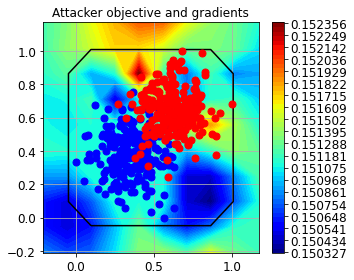

In [ ]:
lb, ub = val.X.min(), val.X.max()  # Bounds of the attack space. Can be set to `None` for unbounded

# Should be chosen depending on the optimization problem
solver_params = {
    'eta': 0.05,
    'eta_min': 0.05,
    'eta_max': None,
    'max_iter': 100,
    'eps': 1e-6
}

from secml.adv.attacks import CAttackPoisoningSVM
pois_attack = CAttackPoisoningSVM(classifier=clf,
                                  training_data=tr,
                                  val=val,
                                  lb=lb, ub=ub,
                                  solver_params=solver_params,
                                  random_seed=random_state)

# chose and set the initial poisoning sample features and label
xc = tr[0,:].X
yc = tr[0,:].Y
pois_attack.x0 = xc
pois_attack.xc = xc
pois_attack.yc = yc

print("Initial poisoning sample features: {:}".format(xc.ravel()))
print("Initial poisoning sample label: {:}".format(yc.item()))

from secml.figure import CFigure
# Only required for visualization in notebooks
%matplotlib inline

fig = CFigure(4,5)

grid_limits = [(lb - 0.1, ub + 0.1),
                    (lb - 0.1, ub + 0.1)]

fig.sp.plot_ds(tr)

# highlight the initial poisoning sample showing it as a star
fig.sp.plot_ds(tr[0,:], markers='*', markersize=16)

fig.sp.title('Attacker objective and gradients')
fig.sp.plot_fun(
    func=pois_attack.objective_function,
    grid_limits=grid_limits, plot_levels=False,
    n_grid_points=10, colorbar=True)

# plot the box constraint
from secml.optim.constraints import CConstraintBox
box = fbox = CConstraintBox(lb=lb, ub=ub)
fig.sp.plot_constraint(box, grid_limits=grid_limits,
                       n_grid_points=10)

fig.tight_layout()
fig.show()

In [ ]:
n_poisoning_points = 20  # Number of poisoning points to generate
pois_attack.n_points = n_poisoning_points

# Run the poisoning attack
print("Attack started...")
pois_y_pred, pois_scores, pois_ds, f_opt = pois_attack.run(ts.X, ts.Y)
print("Attack complete!")

# Evaluate the accuracy of the original classifier
acc = metric.performance_score(y_true=ts.Y, y_pred=y_pred)
# Evaluate the accuracy after the poisoning attack
pois_acc = metric.performance_score(y_true=ts.Y, y_pred=pois_y_pred)

print("Original accuracy on test set: {:.2%}".format(acc))
print("Accuracy after attack on test set: {:.2%}".format(pois_acc))

Attack started...
Attack complete!
Original accuracy on test set: 93.80%
Accuracy after attack on test set: 93.60%


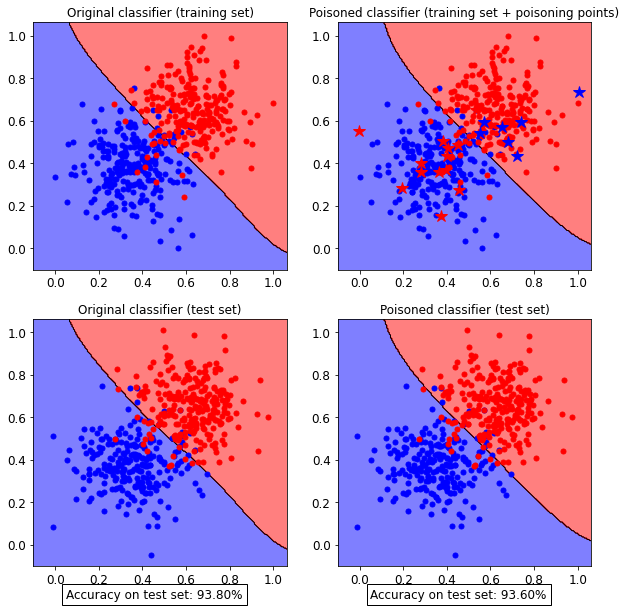

In [ ]:
# Training of the poisoned classifier
pois_clf = clf.deepcopy()
pois_tr = tr.append(pois_ds)  # Join the training set with the poisoning points
pois_clf.fit(pois_tr.X, pois_tr.Y)

# Define common bounds for the subplots
min_limit = min(pois_tr.X.min(), ts.X.min())
max_limit = max(pois_tr.X.max(), ts.X.max())
grid_limits = [[min_limit, max_limit], [min_limit, max_limit]]

fig = CFigure(10, 10)

fig.subplot(2, 2, 1)
fig.sp.title("Original classifier (training set)")
fig.sp.plot_decision_regions(
    clf, n_grid_points=200, grid_limits=grid_limits)
fig.sp.plot_ds(tr, markersize=5)
fig.sp.grid(grid_on=False)

fig.subplot(2, 2, 2)
fig.sp.title("Poisoned classifier (training set + poisoning points)")
fig.sp.plot_decision_regions(
    pois_clf, n_grid_points=200, grid_limits=grid_limits)
fig.sp.plot_ds(tr, markersize=5)
fig.sp.plot_ds(pois_ds, markers=['*', '*'], markersize=12)
fig.sp.grid(grid_on=False)

fig.subplot(2, 2, 3)
fig.sp.title("Original classifier (test set)")
fig.sp.plot_decision_regions(
    clf, n_grid_points=200, grid_limits=grid_limits)
fig.sp.plot_ds(ts, markersize=5)
fig.sp.text(0.05, -0.25, "Accuracy on test set: {:.2%}".format(acc), 
            bbox=dict(facecolor='white'))
fig.sp.grid(grid_on=False)

fig.subplot(2, 2, 4)
fig.sp.title("Poisoned classifier (test set)")
fig.sp.plot_decision_regions(
    pois_clf, n_grid_points=200, grid_limits=grid_limits)
fig.sp.plot_ds(ts, markersize=5)
fig.sp.text(0.05, -0.25, "Accuracy on test set: {:.2%}".format(pois_acc), 
            bbox=dict(facecolor='white'))
fig.sp.grid(grid_on=False)

fig.show()